# ArcGIS API for Python: Cloning Your GIS ##
Bill Major

What are we here to learn about?

- "*We are constantly expanding the capabilities of the ArcGIS API for Python to suit such requirements.*"
- Techniques to clone information from one Web GIS to another 
    + Needs beyond Distributed Collaboration 


What are we here to **not** to learn about?
*  How to move an entire ArcGIS Enterprise (complete environment) from DEV - TEST - DEV
*  How to move an ArcGIS Enterprise environment from one domain to another domain


What works well when cloning?
- Copying web-tier authenticated users
    + No passwords stored
- Groups and Sharing
- Hosted Feature Services
- Web apps based on web app templates and WAB
- Many other item types

*Things that the REST API lends itself to easily*

What doesn't work well when cloning?
- Built-in user accounts (no access to passwords)
    + Create all accounts with a default password
- Hosted Tile Services, Map Services, Image Services
    + By URL reference only
- Complicated Story Maps

*When in doubt, always investigate an item's JSON to gain a better understanding of how well it can be easily copied to another Portal.*
http://wdcintel.maps.arcgis.com/apps/MapJournal/index.html?appid=7c71437449dd468e8949bdfcd404a002
http://wdcintel.maps.arcgis.com/sharing/rest/content/items/7c71437449dd468e8949bdfcd404a002/data?f=pjson


### How do we get started? ###
1. Establish a GIS connection to a source Portal and a GIS connection to a target Portal
2. Copy Users
3. Copy Groups and assign ownership
4. Clone Items

BOOM!

## Establish GIS Connections

In [38]:
from arcgis.gis import GIS

In [39]:
source = GIS(profile="idt_portaladmin")
target = GIS(profile="dev_bill")
target_admin_username = 'Administrator'

In [40]:
source

In [41]:
target

### Copy Users
Create a function that will accept connection to the target portal, `User` objects from source portal and password to create users with. In addition to creating the users, this function will set their access, description, tags and other similar properties from source. If a user by the same name already exists in the target portal (possible if you opted not to clean out the target portal) then this function prints out an error message.

In [44]:
source_users = source.users.search('!esri_ & !admin')
for user in source_users:
    print(user.username + "\t:\t" + str(user.role) + "\t:\t" + str(user.provider) )

anieto	:	org_admin	:	arcgis
bmajor	:	org_admin	:	arcgis
rsingh	:	org_admin	:	arcgis


In [45]:
target_users = target.users.search('!esri_ & !admin & !system_publisher')
for user in target_users:
    print(user.username + "\t:\t" + str(user.role) + "\t:\t" + str(user.provider) )

Administrator	:	org_admin	:	arcgis
bmajor	:	org_admin	:	arcgis


In [46]:
def copy_user(target_portal, source_user, password):
    # See if the user has firstName and lastName properties
    try:
        first_name = source_user.firstName
        last_name = source_user.lastName
    except:
        # if not, split the fullName
        full_name = source_user.fullName
        first_name = full_name.split()[0]
        try:
            last_name = full_name.split()[1]
        except:
            last_name = 'NoLastName'

    try:
        # create user
        target_user = target_portal.users.create(source_user.username, password, first_name, 
                                                 last_name, source_user.email, 
                                                 source_user.description, source_user.role)

        # update user properties
        target_user.update(source_user.access, source_user.preferredView,
                           source_user.description, source_user.tags, 
                           source_user.get_thumbnail_link(),
                           culture=source_user.culture, region=source_user.region)
        return target_user
    
    except Exception as Ex:
        print(str(Ex))
        print("Unable to create user "+ source_user.username)
        return None

In [48]:
existingUsers = []
for u in target_users:
    existingUsers.append(u.username)
existingUsers

['Administrator', 'bmajor']

In [49]:
for user in source_users:
    if not user.username in existingUsers:
        print("Creating user: " + user.username)
        copy_user(target, user, 'TestPassword@123')

Creating user: anieto
Creating user: rsingh


### Copy Groups

In [50]:
# filter out system created groups
source_groups = source.groups.search("!owner:esri_* & !Basemaps & !Featured")
source_groups

[<Group title:"Mali Data" owner:bmajor>,
 <Group title:"TVA Projects" owner:bmajor>]

In [53]:
import tempfile

# List of attributes to copy over
GROUP_COPY_PROPERTIES = ['title', 'description', 'tags', 'snippet', 'phone',
                         'access', 'isInvitationOnly']

def copy_group(target, source, source_group):
    
    with tempfile.TemporaryDirectory() as temp_dir:
        try:
            target_group = {}

            for property_name in GROUP_COPY_PROPERTIES:
                target_group[property_name] = source_group[property_name]

            target_group['access'] = source_group['access']
            
            # Download the thumbnail (if one exists)
            thumbnail_file = None
            if 'thumbnail' in source_group:
                target_group['thumbnail'] = source_group.download_thumbnail(temp_dir)

            # Create the group in the target portal
            copied_group = target.groups.create_from_dict(target_group)

            # Reassign all groups to correct owners, add users, and find shared items
            members = source_group.get_members()

            if members['users']:
                copied_group.add_users(members['users'])
            if not members['owner'] == target_admin_username:
                try:
                    resp = copied_group.reassign_to(members['owner'])
                except:
                    return copied_group
            return copied_group
        except:
            pass

Unable to reassign group.
You already have a group named 'Mali Data'. Try a different name.


<Group title:"Mali Data" owner:bmajor>
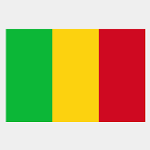

Unable to reassign group.
You already have a group named 'TVA Projects'. Try a different name.


<Group title:"TVA Projects" owner:bmajor>
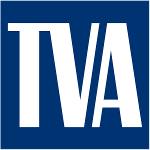

In [54]:
# Dictionary that will hold correlation between source group ids
#   and target group ids; used later
groupmapping = {}

for group in source_groups:
    target_group = copy_group(target, source, group)
    groupmapping[group.id] = target_group.id
    if target_group:
        display(target_group)

In [55]:
groupmapping

{'5462ce0af0cd437c83826a717cbb0bae': 'fffaf6a03e2f4749b8a243fd5cd8ffe3',
 'ac64f9c3853d43829188ed49d06f75f0': '27f66b843a234dad997988b6dfb2194a'}

In [56]:
sourceuser = "bmajor"
user = source.users.get(sourceuser)
items = user.items()
print("--> Root")
for item in items:
    print("\t{} : {} : {}".format(item.title, item.type, item.id))
folders = user.folders
for fld in folders:
    flditems = user.items(fld['title'])
    print("--> " + fld['title'])
    for item in flditems:
        print("\t{} : {} : {}".format(item.title, item.type, item.id))

--> Root
	ColumbiaRiver : Image Service : ff1d16a78c524895b38cc057db466a7a
	Yosemite : Image Service : 312f11fafda847059846c7d48974c161
	Elevation : Image Service : 3165ee28c2f14b0ca6b86c2328ab84ca
	Mali WebMap WAB : Code Attachment : 2b21ab69bd684d7cbf4a2a014ef97fec
	Rivers : File Geodatabase : 07e32ecb34cd4770857e173916cbe0c3
	Rivers : Feature Service : 8e62b131553f4876aff896efd8996778
	watersheds : Shapefile : 3b487f02534441ceb968d8be62a040fe
	watersheds : Feature Service : f3d32bdc6b574dbe9ba9021d280db5f1
	TVA Rivers and Watersheds : Web Map : 985ae99ee83c4447a21cf0a7867b514c
	TVA Rivers and Watersheds : Web Mapping Application : c5807342a49c469795aa46f88e3c0d1c
	Traffic : Map Service : 4e5ed43bf557429f80e0e7d94543a2ac
--> DC
	DC Shopping Mals : Shapefile : 28fe3de2c0294cbf889297e9c185efde
	DC Shopping Mals : Feature Service : ebb1e92caebe4d88ad8d791c88b7d64c
	DC Embassies : Shapefile : 6be0e24b5e314efda822e7ffa0dd688a
	DC Embassies : Feature Service : 5a51576da3b64884a2c09be01f7cf

<Item title:"ColumbiaRiver" type:Imagery Layer owner:bmajor>
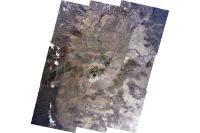

In [59]:
imgserver = source.content.get("ff1d16a78c524895b38cc057db466a7a")
imgserver

## clone_items() ##

This function currently supports all simple data items, for example Pro Project Packages, File Geodatabases, Shapefiles, Code Samples, etc. (any item types that support download). For more complex items, the function supports hosted Web Applications (built using configurable application templates or web app builder), Operation View, Dashboards, Survey123 Forms, Workforce Projects, Web Maps, Hosted Feature Layers, Hosted Feature Layer Views, and Feature Collections. For any of these complex items it will also clone the item’s dependencies. For example if you clone a Web Application, it will also clone the Web Map and any hosted feature layers referenced by the Web Map.

The function does not support cloning of any other service types, for example map services, tile layer, scene layer, etc. If these items are referenced in a web map, the web map will be cloned but it will still reference the original service.


In [60]:
target.content.clone_items?

<Item title:"ColumbiaRiver" type:Imagery Layer owner:bmajor>
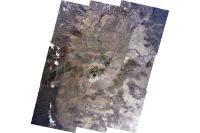

In [61]:
cloned_items = target.content.clone_items(items=[imgserver], copy_data=True, group_mapping=groupmapping)
for ci in cloned_items:
    display(ci)

<Item title:"Rivers" type:Feature Layer Collection owner:bmajor>
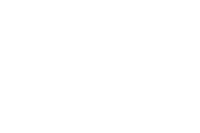

In [62]:
hostedfs = source.content.get("8e62b131553f4876aff896efd8996778")
hostedfs

<Item title:"Rivers" type:Feature Layer Collection owner:bmajor>
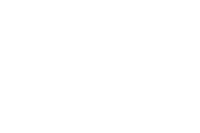

In [63]:
cloned_items = target.content.clone_items(items=[hostedfs], group_mapping=groupmapping)
for ci in cloned_items:
    display(ci)

<Item title:"DC Malls and Embassies Basic Viewer" type:Web Mapping Application owner:bmajor>
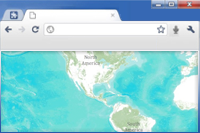

In [64]:
webapp = source.content.get("13c84e8a632c4bbca1035b8f7221b3b5")
webapp

<Item title:"DC Shopping Mals" type:Feature Layer Collection owner:bmajor>

<Item title:"DC Embassies" type:Feature Layer Collection owner:bmajor>
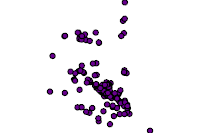

<Item title:"DC Malls and Embassies" type:Web Map owner:bmajor>
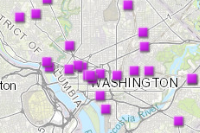

<Item title:"DC Malls and Embassies Basic Viewer" type:Web Mapping Application owner:bmajor>
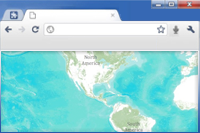

In [65]:
cloned_items = target.content.clone_items(items=[webapp], folder="DC", group_mapping=groupmapping)
for ci in cloned_items:
    display(ci)

In [72]:
wab = source.content.get("e2d31db57ef5440d842bc6dbf310ed1c")
wab

<Item title:"Mali WebMap WAB" type:Web Mapping Application owner:bmajor>

<Item title:"Mali WebMap" type:Web Map owner:bmajor>
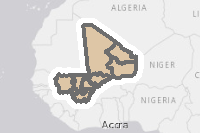

<Item title:"Mali WebMap" type:Web Map owner:bmajor>
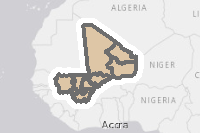

<Item title:"Mali WebMap WAB" type:Web Mapping Application owner:bmajor>

<Item title:"Mali WebMap WAB" type:Web Mapping Application owner:bmajor>

<Item title:"Mali WebMap WAB" type:Code Attachment owner:bmajor>

Item has a Relationship Type that does not allow this.


<Item title:"Mali WebMap WAB" type:Code Attachment owner:bmajor>

In [74]:
cloned_items = target.content.clone_items(items=[wab], copy_data=True, folder="Mali", group_mapping=groupmapping)
for ci in cloned_items:
    display(ci)
    try:
        if wab.access == "org":
            ci.share(everyone=False, org=True, groups="27f66b843a234dad997988b6dfb2194a")
        else:
            ci.share(everyone=True, org=False, groups="27f66b843a234dad997988b6dfb2194a")
    except:
        pass

<Item title:"Traffic" type:Map Image Layer owner:bmajor>
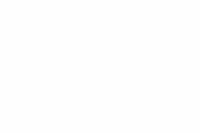

In [68]:
securedsvc = source.content.get("4e5ed43bf557429f80e0e7d94543a2ac")
securedsvc

In [69]:
cloned_items = target.content.clone_items(items=[securedsvc], copy_data=True)
for ci in cloned_items:
    display(ci)

## Future Improvements ##
- Creating disconnected packages that can be moved as a "bundle" between environments
- Handling Secure Service proxy items
- Your input?   https://github.com/Esri/arcgis-python-api